In [1]:
import torch
import os
import math
import logging
import argparse
from statannotations.Annotator import Annotator
from itertools import combinations
# from photo_utils import *
from torchmetrics.image import StructuralSimilarityIndexMeasure
from scipy.ndimage import binary_fill_holes
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import cv2
from torch.nn import L1Loss
from pathlib import Path
import scipy.stats as stats
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns
import csv
import nibabel as nib
from scipy import ndimage
import matplotlib as mpl
from scipy.stats import wilcoxon, ttest_rel, ranksums
# from kornia import morphology as morph
from scipy.stats import mannwhitneyu
from scipy.spatial import cKDTree
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import matplotlib
from matplotlib import colors
import nibabel
import numpy as np

mpl.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Nimbus Roman'],
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Nimbus Roman',
    'mathtext.it': 'Nimbus Roman:italic',
    'mathtext.bf': 'Nimbus Roman:bold',
    'axes.unicode_minus': False
})

def p_to_stars(p):
    if p < 1e-3: return '***'
    if p < 1e-2: return '**'
    if p < 5e-2: return '*'
    return 'ø'

def annotate_significance(ax, df_metric, y_pad_frac=0.02):
    """
    df_metric: summary filtered to the current metric, with columns:
               ['Dist','Method_Label', <metric>]
    Places a single annotation per distance centered between the hue boxes.
    """
    ymin, ymax = ax.get_ylim()
    y_range = ymax - ymin
    for xi, dist in enumerate(distances):
        g1 = df_metric[(df_metric['Method_Label'] == hue_order[0]) & (df_metric['Dist'] == dist)][metric]
        g2 = df_metric[(df_metric['Method_Label'] == hue_order[1]) & (df_metric['Dist'] == dist)][metric]
        if len(g1) == 0 or len(g2) == 0:
            continue
        # Wilcoxon rank-sum (unpaired)
        stat, pval = ranksums(g1, g2)
        stars = p_to_stars(pval)

        y_top = max(g1.max(), g2.max())
        y_text = y_top + y_pad_frac * y_range
        # center between hue boxes at the category tick
        ax.text(xi, y_text, stars, ha='center', va='bottom', fontsize=12)

    # expand ylim a bit to make room for text
    ax.set_ylim(ymin, ymax + 0.08 * y_range)

def get_surface_data_hemis(fname_surf, fname_label):
    surf_wm, _ = nib.freesurfer.read_geometry(f"{fname_surf}.white")
    surf_pial, _ = nib.freesurfer.read_geometry(f"{fname_surf}.pial")
    cort_thickness = np.linalg.norm(surf_wm - surf_pial, axis=1)
    labels, _, _ = nib.freesurfer.read_annot(f"{fname_label}.aparc.annot")
    cthickness = pd.DataFrame({
        "Thickness": cort_thickness,
        "Label": labels.astype(int)
    })
    cthickness = cthickness.groupby("Label", as_index=False)["Thickness"].mean()

    return cthickness, surf_wm, surf_pial, labels


def compute_distance(surf1, surf2):
    dist_s12,_ = cKDTree(surf1).query(surf2, k=1, workers=-1)
    dist_s21,_ = cKDTree(surf2).query(surf1, k=1, workers=-1)
    return dist_s12, dist_s21

def combine_distances(dists_surf12, dists_surf21, i, param):
    mean_dists_12 = float(dists_surf12[dists_surf12["label"]==i].mean()[param])
    mean_dists_21 = float(dists_surf21[dists_surf21["label"]==i].mean()[param])
    value = (mean_dists_12 + mean_dists_21)/2
    return value

#### LOGISTICT FOR CHANGING FONT STYLE
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


/home/scratch/ipykernel_1731836/3330615845.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/home/scratch/ipykernel_1731836/3330615845.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/home/scratch/ipykernel_1731836/3330615845.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


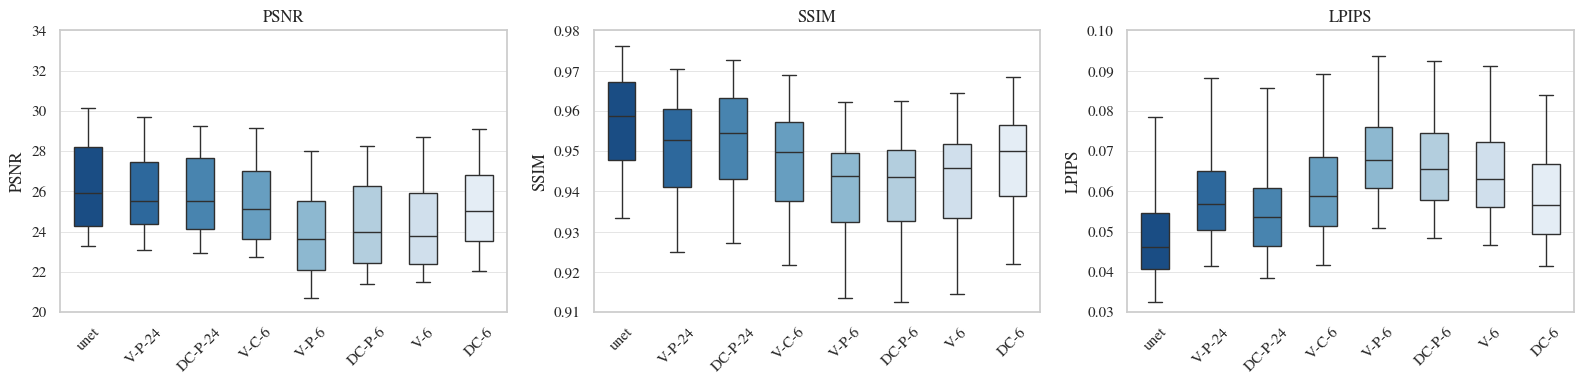

In [85]:
## VOXEL BASED METRICS ##

indir = "/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/"
files = os.listdir(Path(indir))

methods = {
    'unet',
    "_heun_vanilla_vp_10st_resampled",
    "_heun_vanilla_continuity_vp_10st_resampled",
    "_heun_vanilla_perceptual_vp_10st_resampled",
    '-L1_gradient_perceptual-vanilla-vp-24_resampled',
    '-L1_gradient_perceptual-dist_cond-vp-24_resampled',
    "_heun_dist_cond_perceptual_vp_10st_resampled",
    "_heun_dist_cond_vp_10st_resampled",
    
}
methods_labeled = {"unet": "unet", 
                '-L1_gradient_perceptual-vanilla-vp-24_resampled': 'V-P-24',
                '-L1_gradient_perceptual-dist_cond-vp-24_resampled': 'DC-P-24',
                "_heun_dist_cond_perceptual_vp_10st_resampled": "DC-P-6",
                "_heun_dist_cond_vp_10st_resampled": 'DC-6', 
                "_heun_vanilla_continuity_vp_10st_resampled": "V-C-6",
                "_heun_vanilla_perceptual_vp_10st_resampled": "V-P-6",
                "_heun_vanilla_vp_10st_resampled": "V-6",             
}

methods_ordered = ['unet', 'V-P-24', 'DC-P-24', "V-C-6", "V-P-6", "DC-P-6", "V-6",'DC-6']
records = []
psnr_table = []
ssim_table = []
lpips_table = []
labels = []

for file in files:
        file_results =  f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_10-best/voxel_metrics_10.xlsx"
        df = pd.read_excel(file_results)  # rename columns as needed
        df = df.rename(columns={df.columns[0]: "metric"}).set_index("metric")
        for c in df.columns:
            for e in methods:
                if e in c:
                    records.append({
                        'Scan': file,
                        'Method': c,
                        'PSNR': df[c]["PSNR"],
                        'SSIM': df[c]["SSIM"],
                        'LPIPS': df[c]["LPIPS"],     
                    })
        df_long = df.transpose().reset_index()

summary = pd.DataFrame.from_records(records)
summary["Method_Label"] = summary["Method"].map(methods_labeled).fillna(summary["Method"].astype(str))
palette = sns.color_palette("Blues", n_colors=len(methods_ordered))[::-1]
palette = dict(zip(methods_ordered, palette))

sns.set_style("whitegrid", {'font.family': ['serif'], 'font.serif': ['Nimbus Roman']})
metrics = ['PSNR', 'SSIM', 'LPIPS']

# build a palette list in the plotted order (one color per method)
palette_list = [palette[m] for m in methods_ordered]

    #     g1 = summary[(summary['Method'] == 'unet') & (summary['Dist'] == dist)][metric]
    #     g2 = summary[(summary['Method'] == '-L1_gradient_perceptual-dist_cond-vp-24_resampled') & (summary['Dist'] == dist)][metric]
    #     _, pval = mannwhitneyu(g1, g2)
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=False)
for ax, metric in zip(axes, metrics):
    sns.boxplot(
        data=summary,
        x='Method_Label',
        y=metric,
        order=methods_ordered,
        palette=palette_list,
        width=0.5,
        showfliers=False,
        whis=(5, 95),   # whiskers to 5–95th percentile (optional; looks nice)
        linewidth=1,
        ax=ax
    )
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("")                    # no x-label (methods are clear)
    # ax.set_ylabel(metric, fontsize=15)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', linewidth=0.6, alpha=0.6)
    # optional: tighten y-ranges to match your example figure
    if metric == "PSNR":
        ax.set_ylim(20, 34)
    elif metric == "SSIM":
        ax.set_ylim(0.91, 0.98)
    elif metric == "LPIPS":
        ax.set_ylim(0.03, 0.10)

# remove legends (we don’t use hue)
for ax in axes:
    leg = ax.get_legend()
    if leg:
        leg.remove()

plt.tight_layout(w_pad=1.5)
plt.show()

metric_scores = pd.DataFrame()
for method in methods_labeled.values():
    psnr = summary[summary["Method_Label"]==method]["PSNR"]
    ssim = summary[summary["Method_Label"]==method]["SSIM"]
    lpips = summary[summary["Method_Label"]==method]["LPIPS"]

    metric_scores.loc[method,"PSNR"] = psnr.mean() 
    metric_scores.loc[method,"SSIM"] = ssim.mean()
    metric_scores.loc[method,"LPIPS"] = lpips.mean()

    metric_scores.loc[method,"PSNR-stdev"] = np.std(psnr) 
    metric_scores.loc[method,"SSIM-stdev"] = np.std(ssim)
    metric_scores.loc[method,"LPIPS-stdev"] = np.std(lpips)

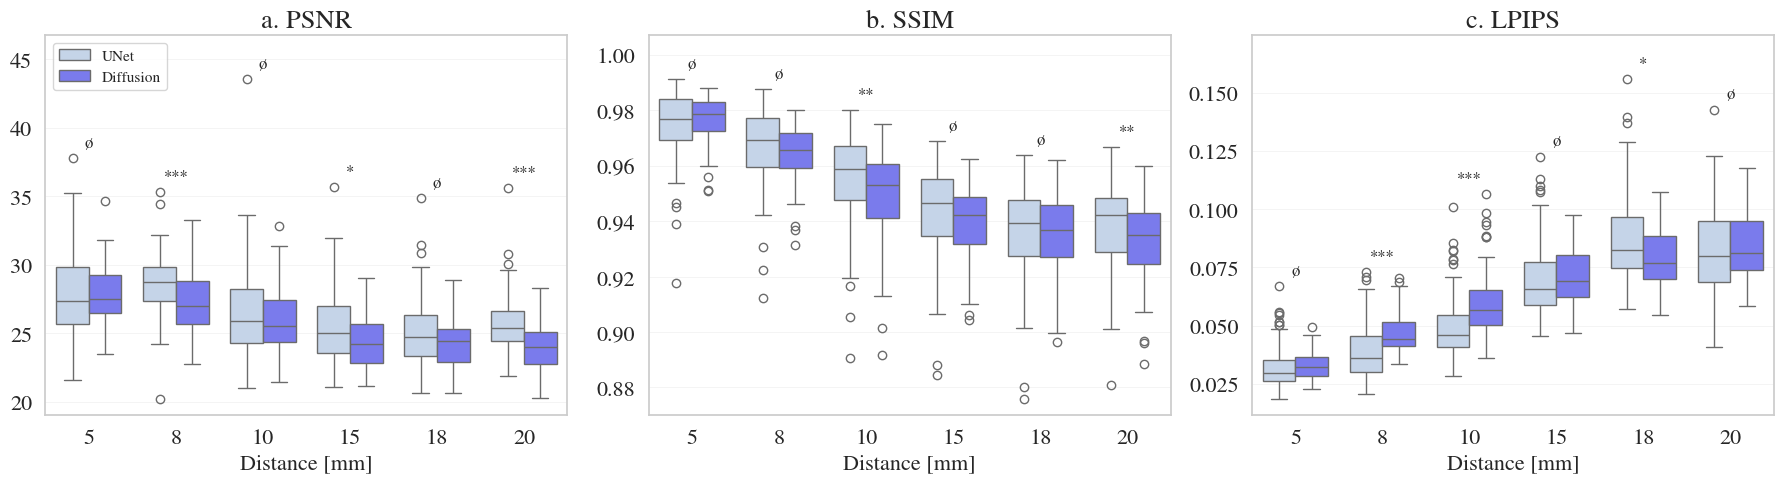

In [ ]:
# --- SETTINGS ---------------------------------------------------------------
metrics = ['PSNR', 'SSIM', 'LPIPS']
distances = ['5', '8', '10', '15', '18', '20']
hue_order = ['unet', 'V-P-vp-24']           # labels already in summary["Method_Label"]
palette = [ "#BFD3EE", "#6768FF",]            # same colors you used
title_labels = ['a. PSNR', 'b. SSIM', 'c. LPIPS']


# --- PLOTTING ---------------------------------------------------------------
# sns.set(style='whitegrid')
stdevs = []
scores = []
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False)
sns.set_style("whitegrid", {'font.family': ['serif'], 'font.serif': ['Nimbus Roman']})
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.boxplot(
        data=summary,
        x="Dist",
        y=metric,
        hue="Method_Label",
        hue_order=hue_order,
        order=distances,
        palette=palette,
        width=0.75,
        ax=ax
    )
    # titles as in your example
    ax.set_title(title_labels[i], fontsize=19)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_xlabel("Distance [mm]", fontsize=16)
    ax.set_ylabel("")
    ax.grid(True, axis='y', linestyle='-', linewidth=0.5, alpha=0.3)

    # significance annotation for this metric
    annotate_significance(ax, summary[['Dist', 'Method_Label', metric]].assign(**{metric: summary[metric]}))
    means_table = pd.DataFrame(index=distances, columns=methods_ordered + ['pval'])
    stdevs_table = pd.DataFrame()
    for dist in ['5', '8', '10', '15', '18', '20']:
        g1 = summary[(summary['Method_Label'] == 'unet') & (summary['Dist'] == dist)][metric]
        g2 = summary[(summary['Method_Label'] == 'V-P-vp-24') & (summary['Dist'] == dist)][metric]
        means_table.loc[dist, 'unet'] = g1.mean()
        means_table.loc[dist, 'V-P-vp-24'] = g2.mean()
        stdevs_table.loc[dist, 'unet']=np.std(g1)
        stdevs_table.loc[dist, 'V-P-vp-24']=np.std(g2)
        if len(g1) == len(g2):
            _, pval = wilcoxon(g1, g2)
            
        else:
            _, pval = wilcoxon(g1[:g2.shape[0]], g2)
        means_table.loc[dist, 'pval'] = pval

    stdevs.append(stdevs_table)
    scores.append(means_table)

# tidy legend (single shared one on the first axis)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['UNet', 'Diffusion'], title=None, frameon=True, loc='upper left')
for j in [1, 2]:
    axes[j].get_legend().remove()

plt.tight_layout()
# plt.show()
# fig.savefig('/homes/1/ma1282/marina_almeria/dbi/workdir/fig_bx_synth_unet_vanilladbi.svg', bbox_inches='tight')


In [3]:

files = {"interp_synthvol_00","interp_synthvol_03","interp_synthvol_05","interp_synthvol_07","interp_synthvol_010",
         "interp_synthvol_011","interp_synthvol_012","interp_synthvol_015","interp_synthvol_016","interp_synthvol_017",
         "interp_synthvol_019","interp_synthvol_021","interp_synthvol_023","interp_synthvol_030","interp_synthvol_031",
         "interp_synthvol_032","interp_synthvol_034","interp_synthvol_036","interp_synthvol_038","interp_synthvol_039",
         "interp_synthvol_040","interp_synthvol_041","interp_synthvol_042","interp_synthvol_043","interp_synthvol_044",
         "interp_synthvol_045","interp_synthvol_046","interp_synthvol_047","interp_synthvol_048","interp_synthvol_055",
         "interp_synthvol_057","interp_synthvol_058","interp_synthvol_061","interp_synthvol_064","interp_synthvol_065",
         "interp_synthvol_075","interp_synthvol_078","interp_synthvol_079","interp_synthvol_080","interp_synthvol_084",
         "interp_synthvol_085","interp_synthvol_088","interp_synthvol_089","interp_synthvol_090","interp_synthvol_094",
         "interp_synthvol_096","interp_synthvol_098","interp_synthvol_099"}
distances = ['5', '8', '10', '15', '18', '20']
missing = []
for file in files:
    for d in distances:
        if d == '10':
            root_dir = f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}-best/synthseg_dbi-L1_gradient_perceptual-vanilla-vp-24.json"
        else:
            root_dir = f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}/synthseg_dbi-L1_gradient_perceptual-vanilla-vp-24.json"
        if not os.path.exists(root_dir):
            missing.append(f"{file}/{d}")



/home/scratch/ipykernel_1731836/898638345.py:71: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Label": int(row["Label"]),  # region id
/home/scratch/ipykernel_1731836/898638345.py:72: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "Dice": float(row["Dice"]),
/home/scratch/ipykernel_1731836/898638345.py:73: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "VE": float(row["VE"]),
/home/scratch/ipykernel_1731836/898638345.py:71: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Label": int(row["Label"]),  # region id
/home/scratch/ipykernel_1731836/898638345.py:72: FutureWarning: Calling float on a single element 

/home/scratch/ipykernel_1731836/898638345.py:71: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Label": int(row["Label"]),  # region id
/home/scratch/ipykernel_1731836/898638345.py:72: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "Dice": float(row["Dice"]),
/home/scratch/ipykernel_1731836/898638345.py:73: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "VE": float(row["VE"]),
/home/scratch/ipykernel_1731836/898638345.py:71: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Label": int(row["Label"]),  # region id
/home/scratch/ipykernel_1731836/898638345.py:72: FutureWarning: Calling float on a single element 

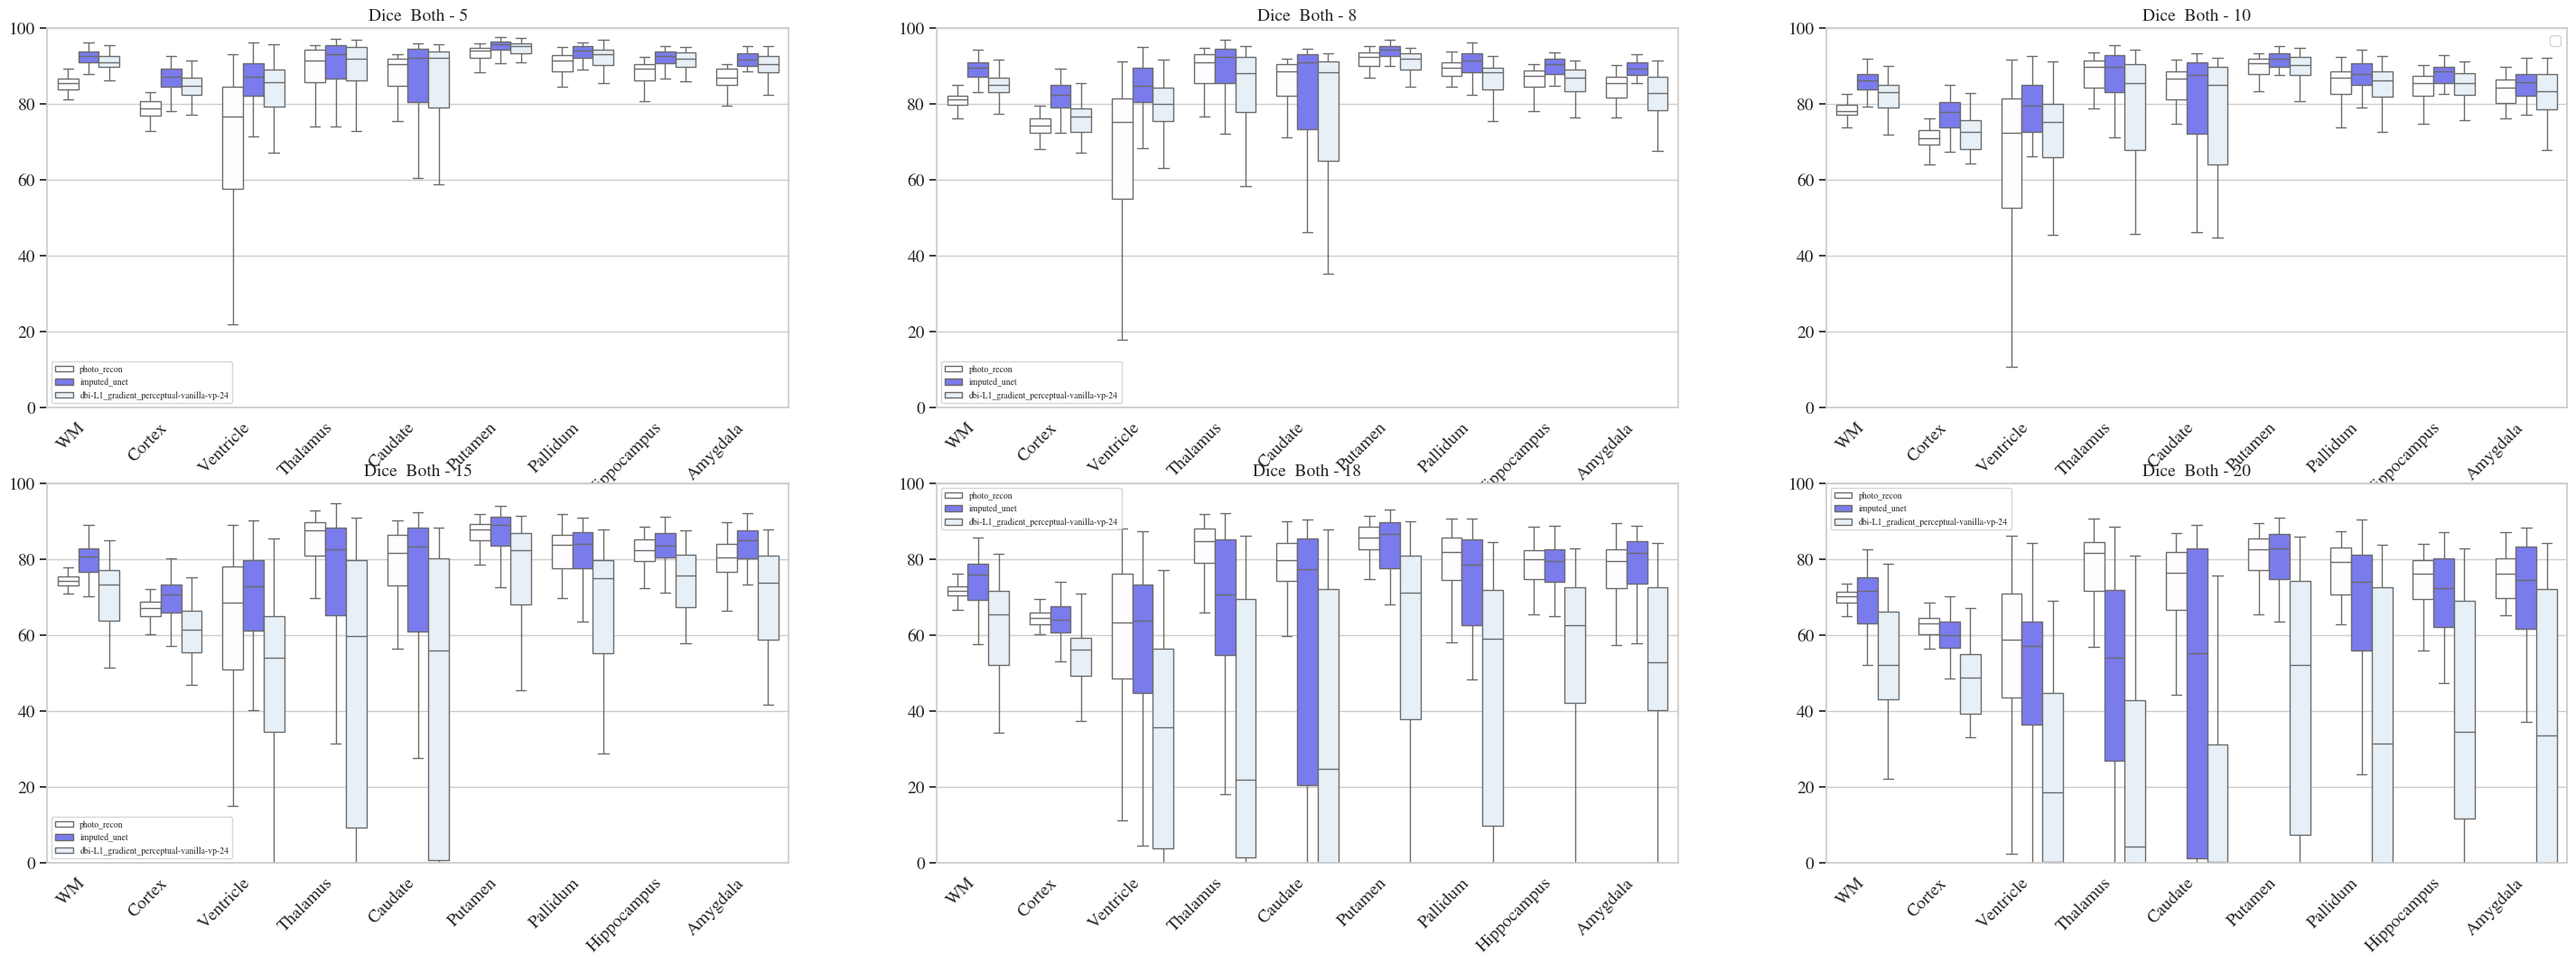

<Figure size 640x480 with 0 Axes>

In [65]:
### SYNTHETIC EXPERIMENTS (Downstream task 1)
methods = {     "photo_recon",
                "imputed_unet",
                'dbi-L1_gradient_perceptual-vanilla-vp-24',
}

methods_labeled_synth = {"imputed_unet": "unet", 
                   "photo_recon_10": 'photo_recon',
                "dbi_heun_vanilla_vp_10st": "V-vp-6",
                "dbi_heun_vanilla_continuity_vp_10st": "V-C-vp-6",
                "dbi_heun_vanilla_perceptual_i2sb_10st": "V-P-i2sb-6",
                "dbi_heun_vanilla_perceptual_vp_10st": "V-P-vp-6",
                'dbi-L1_gradient_perceptual-vanilla-vp-24': 'V-P-vp-24',
                'dbi-L1_gradient_perceptual-dist_cond-vp-24': 'DC-P-vp-24',
                "dbi_heun_dist_cond_perceptual_vp_10st": "DC-P-vp-6",
                "dbi_heun_dist_cond_vp_10st": 'DC-vp-6',
                "dbi_heun_dist_cond_perceptual_i2sb_10st": "DC-P-i2sb-6",
                
}

methods_cp = {"photo_recon_10_vs_imputed_unet": "Photo-UNet", 
              "photo_recon_10_vs_dbi-L1_gradient_perceptual-dist_cond-vp-24": "Photo-DBI",
              "imputed_unet_vs_dbi-L1_gradient_perceptual-dist_cond-vp-24": "DBI-UNet"}



records = []
indir = "/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic"
files = os.listdir(Path(indir))


label_names = { # for synthetic segmentation 
    2:"WM", 3:"Cortex", 4:"Ventricle", 
    10:"Thalamus",
    11:"Caudate", 12:"Putamen", 13:"Pallidum", 17:"Hippocampus",
    18:"Amygdala",
}

files = {"interp_synthvol_00","interp_synthvol_03","interp_synthvol_05","interp_synthvol_07","interp_synthvol_010",
         "interp_synthvol_011","interp_synthvol_012","interp_synthvol_015","interp_synthvol_016","interp_synthvol_017",
         "interp_synthvol_019","interp_synthvol_021","interp_synthvol_023","interp_synthvol_030","interp_synthvol_031",
         "interp_synthvol_032","interp_synthvol_034","interp_synthvol_036","interp_synthvol_038","interp_synthvol_039",
         "interp_synthvol_040","interp_synthvol_041","interp_synthvol_042","interp_synthvol_043","interp_synthvol_044",
         "interp_synthvol_045","interp_synthvol_046","interp_synthvol_047","interp_synthvol_048","interp_synthvol_055",
         "interp_synthvol_057","interp_synthvol_058","interp_synthvol_061","interp_synthvol_064","interp_synthvol_065",
         "interp_synthvol_075","interp_synthvol_078","interp_synthvol_079","interp_synthvol_080","interp_synthvol_084",
         "interp_synthvol_085","interp_synthvol_088","interp_synthvol_089","interp_synthvol_090","interp_synthvol_094",
         "interp_synthvol_096","interp_synthvol_098","interp_synthvol_099"}
distances = ['5','8', '10', '15', '18', '20']
for file in files:
    for method in methods:
        for d in distances:
            file_results = f"{indir}/{file}/dist_{d}/synthseg_{method}.json"
            
            if d == '10':
                file_results = f"{indir}/{file}/dist_10-best/synthseg_{method}.json"

            if os.path.exists(file_results):
                df = pd.read_csv(file_results, sep="\t", header=None)
                df.columns = ["Label", "VE", "Dice", "Jaccard"]  # rename columns as needed
                df = df[df["Label"] != 0]
            
                for i in label_names:
                    if i in df["Label"].values:
                        row = df[df["Label"] == i].copy()
                        
                        records.append({               
                            "Case": file,              # subject/case id
                            "Method": method,          # "unet" or "photo_recon"
                            "Distance": d,
                            "Label": int(row["Label"]),  # region id
                            "Dice": float(row["Dice"]),
                            "VE": float(row["VE"]),
                        })

blue_palette = sns.color_palette("Blues", n_colors=10) # lighter to darker blues
# palette = sns.color_palette("coolwarm", n_colors=10)
palette = ["#FFFBFF"]+["#6768FF"] + blue_palette
summary = pd.DataFrame.from_records(records)
summary["Region"] = summary["Label"].map(label_names).fillna(summary["Label"].astype(str))
summary["Method_Label"] = summary["Method"].map(methods_labeled_synth).fillna(summary["Method"].astype(str))

summary["Region"] = summary["Label"].map(label_names).fillna(summary["Label"].astype(str))
summary["Method_Label"] = summary["Method"].map(methods_labeled_synth).fillna(summary["Method"].astype(str))
methods_compare = ['photo-unet', 'photo-dbi', 'dbi-unet']
methods_ordered = ['photo_recon', 'imputed_unet', 'dbi-L1_gradient_perceptual-vanilla-vp-24']
metric='Dice'

fig, axes = plt.subplots(2, 3, figsize=(12*3, 12), sharey=True)
axes = axes.flatten()
j = 0
distances = ['5', '8', '10', '15','18', '20']
for sub in distances:
    data_sub = summary[summary["Distance"] == sub].copy()

    ax = axes[j]

    sns.boxplot(data=data_sub, y=metric, x="Region",
                hue="Method", hue_order=methods_ordered, palette=palette, dodge=True, showfliers=False, width=0.75, ax=ax)
    ax.set_ylabel("")
    ax.set_xlabel("")

    if j != 2:
        ax.legend(title="", loc="best", fontsize=7)
    else:
        ax.legend('')

    ax.tick_params(axis='y', which='both', left=True, labelleft=True, labelsize=14)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=14)
    ax.set_title(f"{metric}  Both - {sub}", fontsize=14)
    j += 1

    if metric =="Dice":
        plt.ylim(0,100)
    elif metric =="VE":
        plt.ylim(0,150)

        
plt.show()
plt.tight_layout()

n_files = []
mean_dice_table = []
stdevs = []
for dist in distances:
    pvalues_dice_table = pd.DataFrame(index=label_names.values(), columns=["Original", "UNet", "Diffusion"] +methods_compare)
    std_table = pd.DataFrame()
    for label in label_names:
        g2 = summary[(summary['Method'] == 'imputed_unet') & (summary['Distance'] == dist) & (summary['Label'] == label)]['Dice']
        g1 = summary[(summary['Method'] == 'photo_recon') & (summary['Distance'] == dist) & (summary['Label'] == label)]['Dice']
        g3 = summary[(summary['Method'] == 'dbi-L1_gradient_perceptual-vanilla-vp-24') & (summary['Distance'] == dist) & (summary['Label'] == label)]['Dice']
        
        aval_l = min(len(g1), len(g2), len(g3))
        _, pval12 = wilcoxon(g1[:aval_l], g2[:aval_l])
        _, pval23 = wilcoxon(g3[:aval_l], g2[:aval_l])
        _, pval13 = wilcoxon(g3[:aval_l], g1[:aval_l])
        pvalues_dice_table.loc[label_names[label], 'Original'] = g2.mean()
        pvalues_dice_table.loc[label_names[label], 'UNet'] = g1.mean()
        pvalues_dice_table.loc[label_names[label], 'Diffusion'] = g3.mean()
        std_table.loc[label_names[label], 'Original'] = np.std(g2)
        std_table.loc[label_names[label], 'UNet'] = np.std(g1)
        std_table.loc[label_names[label], 'Diffusion'] = np.std(g3)

        pvalues_dice_table.loc[label_names[label], 'photo-unet'] = pval12
        pvalues_dice_table.loc[label_names[label], 'photo-dbi'] = pval13
        pvalues_dice_table.loc[label_names[label], 'dbi-unet'] = pval23

    stdevs.append(std_table)
    mean_dice_table.append(pvalues_dice_table)
fig.savefig(f'/homes/1/ma1282/marina_almeria/dbi/workdir/fig_dice_synth_unet_dbi_6dists_vanilla.svg')

/home/scratch/ipykernel_1731836/1885511485.py:47: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Label": int(row["Label"]),  # region id
/home/scratch/ipykernel_1731836/1885511485.py:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "Dice": float(row["Dice"]),
/home/scratch/ipykernel_1731836/1885511485.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "VE": float(row["VE"]),
/home/scratch/ipykernel_1731836/1885511485.py:47: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Label": int(row["Label"]),  # region id
/home/scratch/ipykernel_1731836/1885511485.py:48: FutureWarning: Calling float on a single ele

/home/scratch/ipykernel_1731836/1885511485.py:47: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Label": int(row["Label"]),  # region id
/home/scratch/ipykernel_1731836/1885511485.py:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "Dice": float(row["Dice"]),
/home/scratch/ipykernel_1731836/1885511485.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "VE": float(row["VE"]),
/home/scratch/ipykernel_1731836/1885511485.py:47: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Label": int(row["Label"]),  # region id
/home/scratch/ipykernel_1731836/1885511485.py:48: FutureWarning: Calling float on a single ele

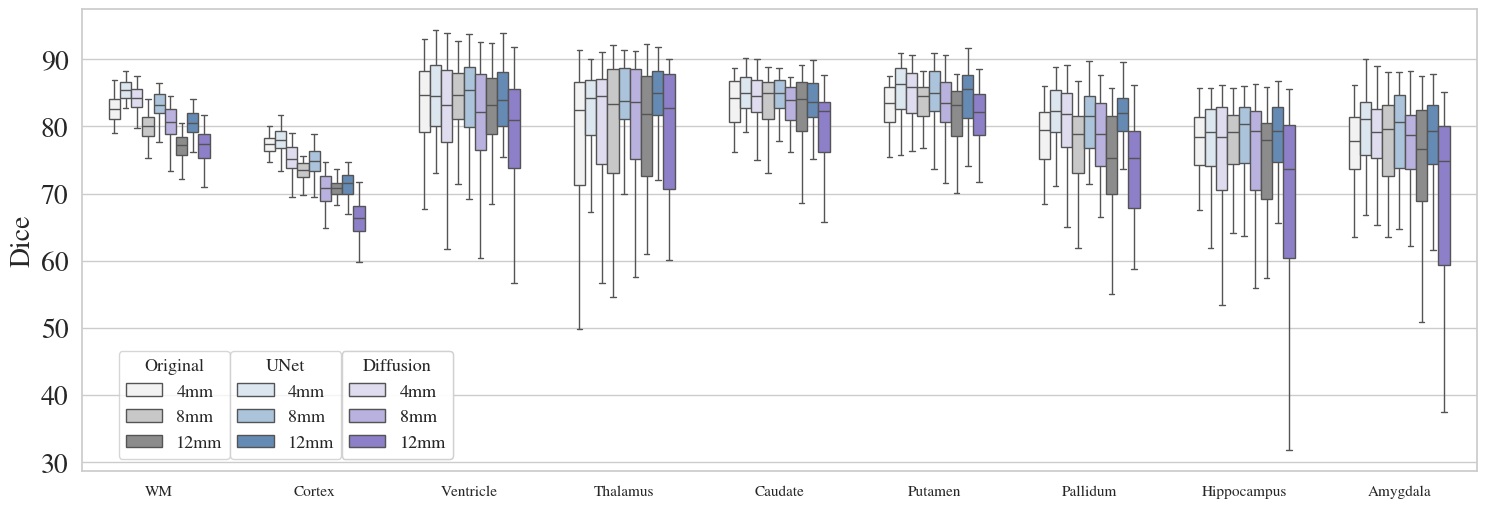

In [91]:
#### TASK 1 : VOLUME SEGMENTATIONS

methods_labeled = { 
    "imputed_unet": "UNet",
    "photo_recon": "Original",
    "dbi-L1_gradient_perceptual-vanilla-vp-24_lr": "Diffusion"
}

records = []
label_names = {2:"WM", 3:"Cortex", 4:"Ventricle", 10:"Thalamus",
        11:"Caudate", 12:"Putamen", 13:"Pallidum", 17:"Hippocampus",
        18:"Amygdala", 
        41:"WM", 42:"Cortex", 43:"Ventricle",49:"Thalamus",
        50:"Caudate", 51:"Putamen", 52:"Pallidum", 53:"Hippocampus",
        54:"Amygdala",
}
label_order = ["WM", "Cortex", "Ventricle", "Thalamus", "Caudate", "Putamen", "Pallidum", "Hippocampus", "Amygdala"]

indir_dbi = '/autofs/space/almeria_001/users/marina/photo_recon_uw/03_synthseg/imputations_dbi'
indir_unet = '/autofs/space/almeria_001/users/marina/photo_recon_uw/03_synthseg/imputations_unet'
indir_photo = '/homes/1/ma1282/marina_almeria/photo_recon_uw/03_synthseg/photo_recon'


## UW Dataset
for sub in ["4mm", "8mm", "12mm"]:
    for file in os.listdir("/homes/1/ma1282/marina_almeria/photo_recon_uw/03_synthseg/imputations_unet"):
        for method in ["photo_recon", "imputed_unet", "dbi-L1_gradient_perceptual-vanilla-vp-24_lr"]:
            if 'photo' in method:
                file_results = f"{indir_photo}/{file}/synthseg_{method}_{sub}.json"
            elif 'unet' in method:
                file_results = f"{indir_unet}/{file}/synthseg_{method}_{sub}.json"
            elif 'dbi' in method:
                file_results = f"{indir_dbi}/{file}/synthseg_{method}_{sub}.json"
        
            df = pd.read_csv(file_results, sep="\t", header=None)
            df.columns = ["Label", "VE", "Dice", "Jaccard"]  # rename columns as needed
            df = df[df["Label"] != 0]
            
            for i in label_names:
                if i in df["Label"].values:
                    row = df[df["Label"] == i].copy()
                    
                    records.append({
                        "Distance": sub,                # e.g., 4, 8, 12 (mm)
                        "Case": file,              # subject/case id
                        "Method": method,          # "unet" or "photo_recon"
                        "Label": int(row["Label"]),  # region id
                        "Dice": float(row["Dice"]),
                        "VE": float(row["VE"]),
                    })


#### VISUALIZATION PURPOSES, PLOTTING ALTOGETHER
summary = pd.DataFrame.from_records(records) 

summary["Region"] = summary["Label"].map(label_names).fillna(summary["Label"].astype(str)) 
summary["Method_Label"] = summary["Method"].map(methods_labeled).fillna(summary["Method"].astype(str)) # 
summary["Hue"] = summary["Method_Label"] + " | " + summary["Distance"]


palette = {
    "Original | 4mm": "#F2F2F2",
    "Original | 8mm": "#C8C8C8",
    "Original | 12mm": "#8C8C8C",
    "UNet | 4mm": "#D8E6F2",
    "UNet | 8mm": "#A3C4E3",
    "UNet | 12mm": "#5889C0",
    "Diffusion | 4mm": "#DDD9F2",
    "Diffusion | 8mm": "#B4A9E6",
    "Diffusion | 12mm": "#8573D4"
}

### PLOT metric='Dice' 
# --- single-axis plot: Baseline/UNet with per-distance colors ---
metric = "Dice"

# 1) build a combined hue and an ordered palette
distances = ["4mm","8mm","12mm"]  # keep your order

hue_order = []
pairs = []
for d in distances:
    hue_order.extend([f"Original | {d}", f"UNet | {d}", f"Diffusion | {d}"])#, f"Diffusion | {d}"])

pairs = []

for d in distances:
    methods_here = [m for m in methods_labeled.values()
                     if ((summary["Distance"] == d) & (summary["Method_Label"] == m)).any()]
    for i,label_name in enumerate(label_names.values()):
        for m1, m2 in combinations(methods_here, 2):
            if i < 9:
                pairs.extend([((f"{label_name}", f"{m1} | {d}"), (f"{label_name}", f"{m2} | {d}"))])


region_order = sorted(summary["Region"].unique(), key=lambda 
                      x: ["WM","Cortex","Ventricle","Thalamus","Caudate","Putamen","Pallidum","Hippocampus","Amygdala"].index(x) 
                      if x in ["WM","Cortex","Ventricle","Thalamus","Caudate","Putamen","Pallidum","Hippocampus","Amygdala"] else 999)

fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(
    data=summary, x="Region", y="Dice",
    hue="Hue", hue_order=hue_order, palette=palette,
    dodge=True, showfliers=False, width=0.65, ax=ax
)
# cosmetics
ax.set_xlabel("")
ax.set_ylabel("Dice", fontsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.grid(True,axis='y')

# 2) split legend into two stacked blocks (Baseline / Proposal)
handles, labels = ax.get_legend_handles_labels()
n = len(distances)
h_orig, h_unet, h_diff = handles[::3], handles[1::3], handles[2::3]
lab_baseline = [d for d in distances]
lab_unet = [d for d in distances]
lab_diffusion = [d for d in distances]
leg1 = ax.legend(h_orig, lab_baseline, title="Original", loc="upper left",
                 bbox_to_anchor=(0.02, 0.28), frameon=True, fontsize=13, title_fontsize=13)
ax.add_artist(leg1)
leg2 = ax.legend(h_unet, lab_unet, title="UNet", loc="upper left",
                 bbox_to_anchor=(0.10, 0.28), frameon=True, fontsize=13, title_fontsize=13)
ax.add_artist(leg2)
  # keep both legends
leg3 = ax.legend(h_diff, lab_diffusion, title="Diffusion", loc="upper left",
                 bbox_to_anchor=(0.18, 0.28), frameon=True, fontsize=13, title_fontsize=13)
ax.add_artist(leg3)

# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=17)
# fig.savefig(f"/homes/1/ma1282/marina_almeria/dbi/workdir/task_1_unet_dbi_photo_volume_segmentations.svg")


metric = "Dice"
methods_cp = ["Orig-UNet", "Orig-Diff", "UNet-Diff"]
mean_table = []
## STATISTICAL SIGNIFICANCE OF RESULTS
pval_distances = []
# with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
for d in distances:

    data_d = summary[summary["Distance"] == d].copy()
    mean_scores = pd.DataFrame()
    pvalues = pd.DataFrame(index=label_names.values(), columns=methods_cp)
    for method in methods_labeled:
        # COMPUTE THE P.VALUES 
        for i in label_names.values():
            if i in data_d["Region"].values:
                # row_i = methods_cp[table_col]
                # m1, m2 = table_col.split("_vs_")
                g1 = data_d[(data_d["Region"] == i) & (data_d["Method_Label"] == "Original")]["Dice"].copy()
                g2 = data_d[(data_d["Region"] == i) & (data_d["Method_Label"] == "UNet")]["Dice"].copy()
                g3 = data_d[(data_d["Region"] == i) & (data_d["Method_Label"] == "Diffusion")]["Dice"].copy()
                _,pval12 = wilcoxon(g1, g2)
                _,pval13 = wilcoxon(g1, g3)
                _,pval23 = wilcoxon(g3, g2)

                mean_scores.loc[i, "Original"] = g1.mean()
                mean_scores.loc[i, "Original-Stdev"] = np.std(g1)
                mean_scores.loc[i, "UNet"] = g2.mean()
                mean_scores.loc[i, "UNet-Stdev"] = np.std(g2)
                mean_scores.loc[i, "Diffusion"] = g3.mean()
                mean_scores.loc[i, "Diffusion-Stdev"] = np.std(g3)

                pvalues["Orig-UNet"][i] = pval12
                pvalues["Orig-Diff"][i] = pval13
                pvalues["UNet-Diff"][i] = pval23
    mean_table.append(mean_scores)
    pval_distances.append(pvalues)
        

/home/scratch/ipykernel_2051130/1053527797.py:29: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Label": int(row["Label"]), # region id
/home/scratch/ipykernel_2051130/1053527797.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "Dice": float(row["Dice"]), })
/home/scratch/ipykernel_2051130/1053527797.py:29: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Label": int(row["Label"]), # region id
/home/scratch/ipykernel_2051130/1053527797.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "Dice": float(row["Dice"]), })
/home/scratch/ipykernel_2051130/1053527797.py:29: FutureWarning: Calling int on a sing

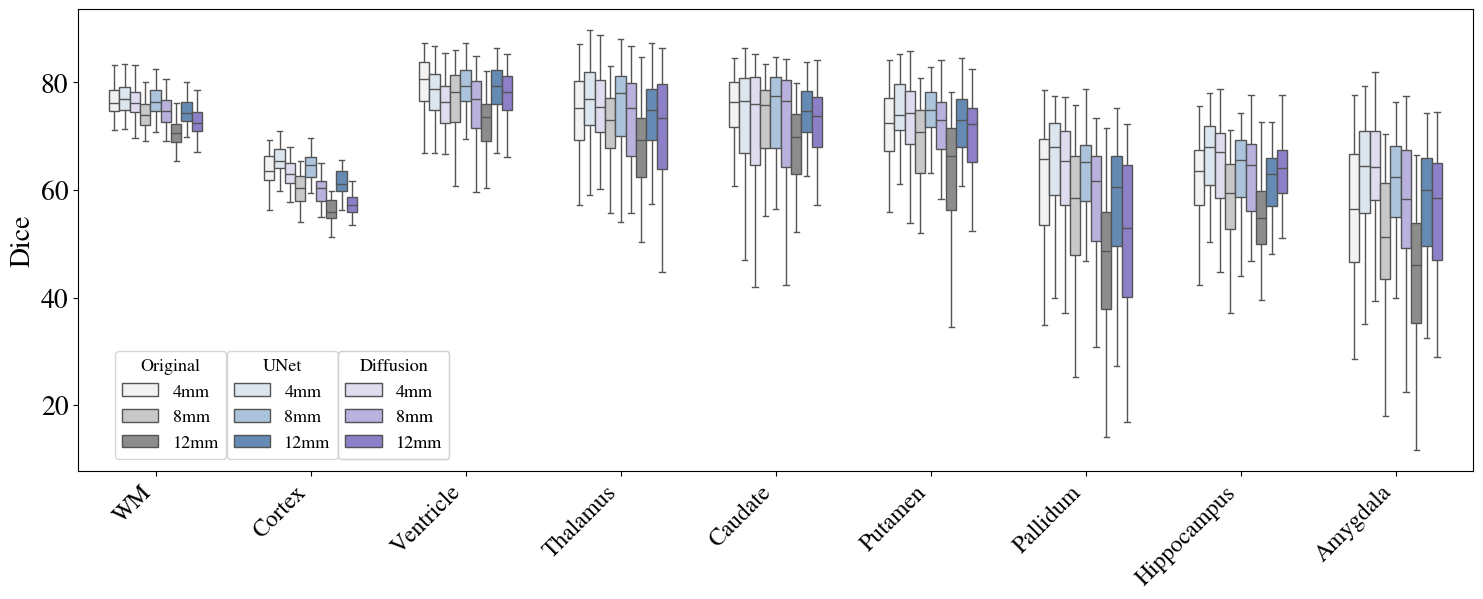

In [3]:
### TASK 3 : ATLAS REGISTRATION 
####################################################################################################
# DBI METHODS -> PLOTTING ALL THE LABELS 
methods = ["to_photos","to_unet","to_dbi"] 
methods_labeled = { "to_photos": "Original", "to_unet": "UNet", "to_dbi": "Diffusion", } 
distances=["4mm", "8mm", "12mm"] # 

records = [] 
indir = '/homes/1/ma1282/marina_almeria/photo_recon_uw/15_registrations_atlas_nifty' 
files = os.listdir("/homes/1/ma1282/marina_almeria/photo_recon_uw/15_registrations_atlas_nifty/to_photos") 

label_names = {2:"WM", 3:"Cortex", 4:"Ventricle", 10:"Thalamus", 11:"Caudate", 12:"Putamen", 13:"Pallidum", 
17:"Hippocampus", 18:"Amygdala",  41:"WM", 42:"Cortex", 43:"Ventricle",49:"Thalamus", 50:"Caudate", 
51:"Putamen", 52:"Pallidum", 53:"Hippocampus", 54:"Amygdala" } 

for d in distances: 
    for file in files: 
        for method in methods: 
            file_results = f"{indir}/{method}/{file}/synthseg_nonlinear_{d}.json" 
            df = pd.read_csv(file_results, sep="\t", header=None) 
            df.columns = ["Label", "VE", "Dice", "Jaccard"] # rename columns as needed 
            df = df[df["Label"] != 0] 
            for i in label_names: 
                if i in df["Label"].values: 
                    row = df[df["Label"] == i].copy() 
                    records.append({"Distance": d, 
                                    "Case": file, # subject/case id 
                                    "Method": method, # "unet" or "photo_recon" 
                                    "Label": int(row["Label"]), # region id 
                                    "Dice": float(row["Dice"]), }) 


summary = pd.DataFrame.from_records(records) 
summary.loc[summary["Method"] == "orig", "Method"] = "to_photos"
summary.loc[summary["Method"] == "machine_learning", "Method"] = "to_unet"

summary["Region"] = summary["Label"].map(label_names).fillna(summary["Label"].astype(str)) 
summary["Method_Label"] = summary["Method"].map(methods_labeled).fillna(summary["Method"].astype(str)) # 
summary["Hue"] = summary["Method_Label"] + " | " + summary["Distance"]


### PLOT metric='Dice' 
# --- single-axis plot: Baseline/UNet with per-distance colors ---
metric = "Dice"

# 1) build a combined hue and an ordered palette

hue_order = []
pairs = []
for d in distances:
    hue_order.extend([f"Original | {d}", f"UNet | {d}", f"Diffusion | {d}"])
    for i,label_name in enumerate(label_names.values()):
        if i < 9:
            pairs.extend([(f"{label_name}", f"Original | {d}"), (f"{label_name}", f"UNet | {d}"),  (f"{label_name}", f"Diffusion | {d}")])
# hue_order = []
# for d in distances:
#     for m in methods:
#         h = f"{m} | {d}"
#         if (summary["Hue"] == h).any():
#             hue_order.append(h)

# pairs = []
# for r in label_names.values():
#     for d in distances:
#         hues_here = [f"{m} | {d}" for m in methods if ((summary["Region"] == r) & (summary["Hue"] == f"{m} | {d}")).any()]
#         for h1, h2 in combinations(hues_here, 2):
#             pairs.append(((r, h1), (r, h2)))

palette = {
    "Original | 4mm": "#F2F2F2",
    "Original | 8mm": "#C8C8C8",
    "Original | 12mm": "#8C8C8C",
    "UNet | 4mm": "#D8E6F2",
    "UNet | 8mm": "#A3C4E3",
    "UNet | 12mm": "#5889C0",
    "Diffusion | 4mm": "#DDD9F2",
    "Diffusion | 8mm": "#B4A9E6",
    "Diffusion | 12mm": "#8573D4"
}

region_order = sorted(summary["Region"].unique(), key=lambda 
                      x: ["WM","Cortex","Ventricle","Thalamus","Caudate","Putamen","Pallidum","Hippocampus","Amygdala"].index(x) 
                      if x in ["WM","Cortex","Ventricle","Thalamus","Caudate","Putamen","Pallidum","Hippocampus","Amygdala"] else 999)

fig, ax = plt.subplots(figsize=(18, 6))

sns.boxplot(
    data=summary, x="Region", y="Dice",
    hue="Hue", hue_order=hue_order, palette=palette,
    dodge=True, showfliers=False, width=0.6, ax=ax
)


# cosmetics
ax.set_xlabel("")
ax.set_ylabel("Dice", fontsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.legend(title="Method", loc="lower left", frameon=True, fontsize=12)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=17)

# 2) split legend into two stacked blocks (Baseline / Proposal)
handles, labels = ax.get_legend_handles_labels()
n = len(distances)
h_orig, h_unet, h_diff = handles[::3], handles[1::3], handles[2::3]
lab_baseline = [d for d in distances]
lab_unet = [d for d in distances]
lab_diffusion = [d for d in distances]
leg1 = ax.legend(h_orig, lab_baseline, title="Original", loc="upper left",
                 bbox_to_anchor=(0.02, 0.28), frameon=True, fontsize=13, title_fontsize=13)
ax.add_artist(leg1)
leg2 = ax.legend(h_unet, lab_unet, title="UNet", loc="upper left",
                 bbox_to_anchor=(0.10, 0.28), frameon=True, fontsize=13, title_fontsize=13)
ax.add_artist(leg2)
  # keep both legends
leg3 = ax.legend(h_diff, lab_diffusion, title="Diffusion", loc="upper left",
                 bbox_to_anchor=(0.18, 0.28), frameon=True, fontsize=13, title_fontsize=13)
ax.add_artist(leg3)

# ax.set_title(f"{metric}", fontsize=16)

metric = "Dice"
methods_cp = ["Orig-UNet", "Orig-Diff", "UNet-Diff"]

## STATISTICAL SIGNIFICANCE OF RESULTS
pval_distances = []
mean_tables = []
# with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
for d in distances:

    data_d = summary[summary["Distance"] == d].copy()
    mean_scores = pd.DataFrame()
    pvalues = pd.DataFrame(index=label_names.values(), columns=methods_cp)
    for method in methods_labeled:
        # COMPUTE THE P.VALUES 
        for i in label_names.values():
            if i in data_d["Region"].values:
                # row_i = methods_cp[table_col]
                # m1, m2 = table_col.split("_vs_")
                g1 = data_d[(data_d["Region"] == i) & (data_d["Method_Label"] == "Original")]["Dice"].copy()
                g2 = data_d[(data_d["Region"] == i) & (data_d["Method_Label"] == "UNet")]["Dice"].copy()
                g3 = data_d[(data_d["Region"] == i) & (data_d["Method_Label"] == "Diffusion")]["Dice"].copy()
                _,pval12 = wilcoxon(g1, g2)
                _,pval13 = wilcoxon(g1, g3)
                _,pval23 = wilcoxon(g3, g2)
                mean_scores.loc[i, "Original"] = g1.mean()
                mean_scores.loc[i, "Original-Stdev"] = np.std(g1)
                mean_scores.loc[i, "UNet"] = g2.mean()
                mean_scores.loc[i, "UNet-Stdev"] = np.std(g2)
                mean_scores.loc[i, "Diffusion"] = g3.mean()
                mean_scores.loc[i, "Diffusion-Stdev"] = np.std(g3)

                pvalues["Orig-UNet"][i] = pval12
                pvalues["Orig-Diff"][i] = pval13
                pvalues["UNet-Diff"][i] = pval23
    pval_distances.append(pvalues)
    mean_tables.append(mean_scores)
        
        
# fig.savefig(f"/homes/1/ma1282/marina_almeria/dbi/workdir/task_3_diffusion_unet_photo_atlasregistration.svg")        

In [13]:
### TASK 3 : ATLAS Segmentation Results - JOINT
####################################################################################################
# DBI METHODS -> PLOTTING ALL THE LABELS 
methods = ["to_photos","to_unet","to_dbi"] 
methods_labeled = { "to_photos": "Origin", "to_unet": "UNet", "to_dbi": "Diffusion", } 
distances=["4mm", "8mm", "12mm"] # 

records = [] 
indir = '/homes/1/ma1282/marina_almeria/photo_recon_uw/15_registrations_atlas' 
files = os.listdir("/homes/1/ma1282/marina_almeria/photo_recon_uw/15_registrations_atlas/to_photos") 

label_names = {2:"WM", 3:"Cortex", 4:"Ventricle", 10:"Thalamus", 11:"Caudate", 12:"Putamen", 13:"Pallidum", 
17:"Hippocampus", 18:"Amygdala",  41:"WM", 42:"Cortex", 43:"Ventricle",49:"Thalamus", 50:"Caudate", 
51:"Putamen", 52:"Pallidum", 53:"Hippocampus", 54:"Amygdala" } 

for d in distances: 
    for file in files: 
        for method in methods: 
            file_results = f"{indir}/{method}/{file}/synthseg_nonlinear_{d}.json" 
            df = pd.read_csv(file_results, sep="\t", header=None) 
            df.columns = ["Label", "VE", "Dice", "Jaccard"] # rename columns as needed 
            df = df[df["Label"] != 0] 
            for i in label_names: 
                if i in df["Label"].values: 
                    row = df[df["Label"] == i].copy() 
                    records.append({"Distance": d, 
                                    "Case": file, # subject/case id 
                                    "Method": method, # "unet" or "photo_recon" 
                                    "Label": int(row["Label"]), # region id 
                                    "Dice": float(row["Dice"]), }) 


summary = pd.DataFrame.from_records(records) 
summary.loc[summary["Method"] == "orig", "Method"] = "to_photos"
summary.loc[summary["Method"] == "machine_learning", "Method"] = "to_unet"

summary["Region"] = summary["Label"].map(label_names).fillna(summary["Label"].astype(str)) 
summary["Method_Label"] = summary["Method"].map(methods_labeled).fillna(summary["Method"].astype(str)) # 
summary["Hue"] = summary["Method_Label"] + " | " + summary["Distance"]


### PLOT metric='Dice' 
# --- single-axis plot: Baseline/UNet with per-distance colors ---
metric = "Dice"

# 1) build a combined hue and an ordered palette

hue_order = []
pairs = []
for d in distances:
    hue_order.extend([f"Origin | {d}", f"UNet | {d}", f"Diffusion | {d}"])
    for i,label_name in enumerate(label_names.values()):
        if i < 9:
            pairs.extend([(f"{label_name}", f"Origin | {d}"), (f"{label_name}", f"UNet | {d}"),  (f"{label_name}", f"Diffusion | {d}")])

palette = {
    "Origin | 4mm": "#F2F2F2",
    "Origin | 8mm": "#C8C8C8",
    "Origin | 12mm": "#8C8C8C",
    "UNet | 4mm": "#D8E6F2",
    "UNet | 8mm": "#A3C4E3",
    "UNet | 12mm": "#5889C0",
    "Diffusion | 4mm": "#DDD9F2",
    "Diffusion | 8mm": "#B4A9E6",
    "Diffusion | 12mm": "#8573D4"
}

region_order = sorted(summary["Region"].unique(), key=lambda 
                      x: ["WM","Cortex","Ventricle","Thalamus","Caudate","Putamen","Pallidum","Hippocampus","Amygdala"].index(x) 
                      if x in ["WM","Cortex","Ventricle","Thalamus","Caudate","Putamen","Pallidum","Hippocampus","Amygdala"] else 999)

fig, ax = plt.subplots(figsize=(18, 6))

sns.boxplot(
    data=summary, x="Region", y="Dice",
    hue="Hue", hue_order=hue_order, palette=palette,
    dodge=True, showfliers=False, width=0.65, ax=ax
)

# cosmetics
ax.set_xlabel("")
ax.set_ylabel("Dice", fontsize=18)
ax.tick_params(axis="y", labelsize=18)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=18)

# 2) split legend into two stacked blocks (Baseline / Proposal)
handles, labels = ax.get_legend_handles_labels()
n = len(distances)
h_orig, h_unet, h_diff = handles[::3], handles[1::3], handles[2::3]
lab_baseline = [d for d in distances]
lab_unet = [d for d in distances]
lab_diffusion = [d for d in distances]
leg1 = ax.legend(h_orig, lab_baseline, title="Original", loc="upper left",
                 bbox_to_anchor=(0.02, 0.28), frameon=True, fontsize=13, title_fontsize=13)
ax.add_artist(leg1)
leg2 = ax.legend(h_unet, lab_unet, title="UNet", loc="upper left",
                 bbox_to_anchor=(0.10, 0.28), frameon=True, fontsize=13, title_fontsize=13)
ax.add_artist(leg2)
  # keep both legends
leg3 = ax.legend(h_diff, lab_diffusion, title="Diffusion", loc="upper left",
                 bbox_to_anchor=(0.18, 0.28), frameon=True, fontsize=13, title_fontsize=13)
ax.add_artist(leg3)
ax.grid(True, axis='y')

        
fig.savefig(f"/homes/1/ma1282/marina_almeria/dbi/workdir/task_3_diffusion_unet_photo_atlasregistration.svg")        

FileNotFoundError: [Errno 2] No such file or directory: '/homes/1/ma1282/marina_almeria/photo_recon_uw/15_registrations_atlas/to_photos'

In [2]:
#### TASK 2 : SURFACE RECONSTRUCTIONS
#### UW DATASET SURFACE RECONSTRUCTION RESULTS
#####################################################################################
files = os.listdir("/homes/1/ma1282/marina_almeria/photo_recon_uw/00_photo_recon")
both = 0
left_cases = 0
right_cases = 0
l_reports_recon = []
r_reports_recon = []

for file in files:
    name_mri = f"/homes/1/ma1282/marina_almeria/photo_recon_uw/12_recon_any_original_mri_deformed/{file}"
    name_dbi = f"/homes/1/ma1282/marina_almeria/photo_recon_uw/14_recon_any_imputations_dbi_vanilla/{file}"
    name_unet = f"/homes/1/ma1282/marina_almeria/photo_recon_uw/11_recon_any_imputations_unet/{file}"
    name_photo = f"/homes/1/ma1282/marina_almeria/photo_recon_uw/10_recon_any_photo/{file}"

    lh_cthick_gt, lh_surf_wm, lh_surf_pial, lh_labels = get_surface_data_hemis(f"{name_mri}/mri/surf/lh", f"{name_mri}/mri/label/lh")
    rh_cthick_gt, rh_surf_wm, rh_surf_pial, rh_labels = get_surface_data_hemis(f"{name_mri}/mri/surf/rh", f"{name_mri}/mri/label/rh")

    ## CORTICAL THICKNESS 
    dists_pmri = pd.DataFrame()
    dists_umri = pd.DataFrame()

    for d in ["4mm", "8mm", "12mm"]:

        #### Cortical Surface GT
        lh_dists_pmri = pd.DataFrame()
        lh_dists_pmri["label"] = lh_labels.astype(int)
        lh_dists_umri  = lh_dists_pmri.copy()
        lh_dists_dbimri = lh_dists_pmri.copy()

        rh_dists_pmri = pd.DataFrame()
        rh_dists_pmri["label"] = rh_labels.astype(int)
        rh_dists_umri = rh_dists_pmri.copy()
        rh_dists_dbimri = rh_dists_pmri.copy()

        lh_cthickness_photo, lh_surf_wm_photo, lh_surf_pial_photo, lh_label_photo = get_surface_data_hemis(f"{name_photo}/photo_recon_resampled_{d}/surf/lh", f"{name_photo}/photo_recon_resampled_{d}/label/lh" )    
        rh_cthickness_photo, rh_surf_wm_photo, rh_surf_pial_photo, rh_label_photo = get_surface_data_hemis(f"{name_photo}/photo_recon_resampled_{d}/surf/rh", f"{name_photo}/photo_recon_resampled_{d}/label/rh" )    

        lh_cthickness_unet, lh_surf_wm_unet, lh_surf_pial_unet, lh_label_unet = get_surface_data_hemis(f"{name_unet}/imputed_unet_resampled_{d}/surf/lh", f"{name_unet}/imputed_unet_resampled_{d}/label/lh" )    
        rh_cthickness_unet, rh_surf_wm_unet, rh_surf_pial_unet, rh_label_unet = get_surface_data_hemis(f"{name_unet}/imputed_unet_resampled_{d}/surf/rh", f"{name_unet}/imputed_unet_resampled_{d}/label/rh" )    

        lh_cthickness_dbi, lh_surf_wm_dbi, lh_surf_pial_dbi, lh_label_dbi = get_surface_data_hemis(f"{name_dbi}/imputed_dbi_{d}/surf/lh", f"{name_dbi}/imputed_dbi_{d}/label/lh" )    
        rh_cthickness_dbi, rh_surf_wm_dbi, rh_surf_pial_dbi, rh_label_dbi = get_surface_data_hemis(f"{name_dbi}/imputed_dbi_{d}/surf/rh", f"{name_dbi}/imputed_dbi_{d}/label/rh" )    

        ##################################################################################
        #### PHOTO
        #### LEFT HEMISPHERE

        lh_dists_photo2mri = pd.DataFrame()
        lh_dists_mri2photo = pd.DataFrame()
        lh_dists_photo2mri["label"] = lh_label_photo.astype(np.int32)
        lh_dists_mri2photo["label"] = lh_labels.astype(np.int32)
        
        lh_dists_photo2mri["distance_wm"], lh_dists_mri2photo["distance_wm"] = compute_distance(lh_surf_wm, lh_surf_wm_photo)
        lh_dists_photo2mri["distance_pial"], lh_dists_mri2photo["distance_pial"]  = compute_distance(lh_surf_pial, lh_surf_pial_photo)
        lh_cthickness_photogt = pd.DataFrame(np.abs(lh_cthick_gt["Thickness"] - lh_cthickness_photo["Thickness"]))
        lh_cthickness_photogt["Label"] = lh_cthick_gt["Label"]
        #### RIGHT HEMISPHERE
        rh_dists_photo2mri = pd.DataFrame()
        rh_dists_mri2photo = pd.DataFrame()
        rh_dists_photo2mri["label"] = rh_label_photo.astype(np.int32)
        rh_dists_mri2photo["label"] = rh_labels.astype(np.int32)
        
        rh_dists_photo2mri["distance_wm"], rh_dists_mri2photo["distance_wm"] = compute_distance(rh_surf_wm, rh_surf_wm_photo)
        rh_dists_photo2mri["distance_pial"], rh_dists_mri2photo["distance_pial"] = compute_distance(rh_surf_pial, rh_surf_pial_photo)
        rh_cthickness_photogt = pd.DataFrame(np.abs(rh_cthickness_photo["Thickness"] - rh_cthick_gt["Thickness"]))
        rh_cthickness_photogt['Label'] = rh_cthickness_photo['Label']
        # ##################################################################################
        #### UNET
        #### LEFT HEMISPHERE

        lh_dists_unet2mri = pd.DataFrame()
        lh_dists_mri2unet = pd.DataFrame()
        lh_dists_unet2mri["label"] = lh_label_unet.astype(np.int32)
        lh_dists_mri2unet["label"] = lh_labels.astype(np.int32)
        
        lh_dists_unet2mri["distance_wm"], lh_dists_mri2unet["distance_wm"] = compute_distance(lh_surf_wm, lh_surf_wm_unet)
        lh_dists_unet2mri["distance_pial"], lh_dists_mri2unet["distance_pial"] = compute_distance(lh_surf_pial, lh_surf_pial_unet)
        lh_cthickness_unetgt = pd.DataFrame(np.abs(lh_cthick_gt["Thickness"] - lh_cthickness_unet["Thickness"]))
        lh_cthickness_unetgt["Label"] = lh_cthick_gt["Label"]
        #### RIGHT HEMISPHERE
        rh_dists_unet2mri = pd.DataFrame()
        rh_dists_mri2unet = pd.DataFrame()
        rh_dists_unet2mri["label"] = rh_label_unet.astype(np.int32)
        rh_dists_mri2unet["label"] = rh_labels.astype(np.int32)

        rh_dists_unet2mri["distance_wm"], rh_dists_mri2unet["distance_wm"] = compute_distance(rh_surf_wm, rh_surf_wm_unet)
        rh_dists_unet2mri["distance_pial"], rh_dists_mri2unet["distance_pial"] = compute_distance(rh_surf_pial, rh_surf_pial_unet)
        rh_cthickness_unetgt = pd.DataFrame(np.abs(rh_cthickness_unet["Thickness"] - rh_cthick_gt["Thickness"]))
        rh_cthickness_unetgt['Label'] = rh_cthickness_unet['Label']

        # ##################################################################################
        #### DBI
        #### LEFT HEMISPHERE

        lh_dists_dbi2mri = pd.DataFrame()
        lh_dists_mri2dbi = pd.DataFrame()
        lh_dists_dbi2mri["label"] = lh_label_dbi.astype(np.int32)
        lh_dists_mri2dbi["label"] = lh_labels.astype(np.int32)
        
        lh_dists_dbi2mri["distance_wm"], lh_dists_mri2dbi["distance_wm"] = compute_distance(lh_surf_wm, lh_surf_wm_dbi)
        lh_dists_dbi2mri["distance_pial"], lh_dists_mri2dbi["distance_pial"] = compute_distance(lh_surf_pial, lh_surf_pial_dbi)
        lh_cthickness_dbigt = pd.DataFrame(np.abs(lh_cthick_gt["Thickness"] - lh_cthickness_dbi["Thickness"]))
        lh_cthickness_dbigt["Label"] = lh_cthick_gt["Label"]
        #### RIGHT HEMISPHERE
        rh_dists_dbi2mri = pd.DataFrame()
        rh_dists_mri2dbi = pd.DataFrame()
        rh_dists_dbi2mri["label"] = rh_label_dbi.astype(np.int32)
        rh_dists_mri2dbi["label"] = rh_labels.astype(np.int32)

        rh_dists_dbi2mri["distance_wm"], rh_dists_mri2dbi["distance_wm"] = compute_distance(rh_surf_wm, rh_surf_wm_dbi)
        rh_dists_dbi2mri["distance_pial"], rh_dists_mri2dbi["distance_pial"] = compute_distance(rh_surf_pial, rh_surf_pial_dbi)
        rh_cthickness_dbigt = pd.DataFrame(np.abs(rh_cthickness_dbi["Thickness"] - rh_cthick_gt["Thickness"]))
        rh_cthickness_dbigt['Label'] = rh_cthickness_dbi['Label']


        for _,l in enumerate(lh_cthickness_unet["Label"]):
            l_mean_cortical_unet = float(lh_cthickness_unetgt[lh_cthickness_unetgt["Label"] == l]["Thickness"])
            l_mean_cortical_photo = float(lh_cthickness_photogt[lh_cthickness_photogt["Label"] == l]["Thickness"])
            l_mean_cortical_dbi = float(lh_cthickness_dbigt[lh_cthickness_dbigt["Label"] == l]["Thickness"])

            lh_dist_labels_photo_wm = combine_distances(lh_dists_photo2mri, lh_dists_mri2photo, l, "distance_wm")
            lh_dist_labels_unet_wm = combine_distances(lh_dists_mri2unet, lh_dists_unet2mri, l, "distance_wm")
            lh_dist_labels_dbi_wm = combine_distances(lh_dists_mri2dbi, lh_dists_dbi2mri, l, "distance_wm")

            lh_dist_labels_photo_pial = combine_distances(lh_dists_photo2mri, lh_dists_mri2photo, l, "distance_pial")
            lh_dist_labels_unet_pial = combine_distances(lh_dists_mri2unet, lh_dists_unet2mri, l, "distance_pial")
            lh_dist_labels_dbi_pial = combine_distances(lh_dists_mri2dbi, lh_dists_dbi2mri, l, "distance_pial")


            l_reports_recon.append({
            "file": file,
            "label":l,
            "distance": d,
            "cortical_unet":l_mean_cortical_unet,
            "cortical_baseline":l_mean_cortical_photo,
            "cortical_diffusion":l_mean_cortical_dbi,
            "err_wm_baseline": lh_dist_labels_photo_wm,
            "err_wm_unet": lh_dist_labels_unet_wm,
            "err_wm_diffusion": lh_dist_labels_dbi_wm,
            "err_pial_baseline": lh_dist_labels_photo_pial,
            "err_pial_unet": lh_dist_labels_unet_pial,
            "err_pial_diffusion": lh_dist_labels_dbi_pial,
        })

        for _,l in enumerate(rh_cthickness_unet["Label"]):
            r_mean_cortical_unet = float(rh_cthickness_unetgt[rh_cthickness_unetgt["Label"] == l]["Thickness"])
            r_mean_cortical_photo = float(rh_cthickness_photogt[rh_cthickness_photogt["Label"] == l]["Thickness"])
            r_mean_cortical_dbi = float(rh_cthickness_dbigt[rh_cthickness_dbigt["Label"] == l]["Thickness"])

            rh_dist_labels_photo_wm = combine_distances(rh_dists_photo2mri, rh_dists_mri2photo, l, "distance_wm")
            rh_dist_labels_unet_wm = combine_distances(rh_dists_mri2unet, rh_dists_unet2mri, l, "distance_wm")
            rh_dist_labels_dbi_wm = combine_distances(rh_dists_mri2dbi, rh_dists_dbi2mri, l, "distance_wm")

            rh_dist_labels_photo_pial = combine_distances(rh_dists_photo2mri, rh_dists_mri2photo, l, "distance_pial")
            rh_dist_labels_unet_pial = combine_distances(rh_dists_mri2unet, rh_dists_unet2mri, l, "distance_pial")
            rh_dist_labels_dbi_pial = combine_distances(rh_dists_mri2dbi, rh_dists_dbi2mri, l, "distance_pial")


            r_reports_recon.append({
            "file": file,
            "label":l,
            "distance": d,
            "cortical_unet":r_mean_cortical_unet,
            "cortical_baseline":r_mean_cortical_photo,
            "cortical_diffusion":r_mean_cortical_dbi,
            "err_wm_baseline": rh_dist_labels_photo_wm,
            "err_wm_unet": rh_dist_labels_unet_wm,
            "err_wm_diffusion": rh_dist_labels_dbi_wm,
            "err_pial_baseline": rh_dist_labels_photo_pial,
            "err_pial_unet": rh_dist_labels_unet_pial,
            "err_pial_diffusion": rh_dist_labels_dbi_pial,
        })
l_reports_recon = pd.DataFrame.from_records(l_reports_recon)
r_reports_recon = pd.DataFrame.from_records(r_reports_recon)

/home/scratch/ipykernel_3823456/3778543820.py:119: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  l_mean_cortical_unet = float(lh_cthickness_unetgt[lh_cthickness_unetgt["Label"] == l]["Thickness"])
/home/scratch/ipykernel_3823456/3778543820.py:120: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  l_mean_cortical_photo = float(lh_cthickness_photogt[lh_cthickness_photogt["Label"] == l]["Thickness"])
/home/scratch/ipykernel_3823456/3778543820.py:121: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  l_mean_cortical_dbi = float(lh_cthickness_dbigt[lh_cthickness_dbigt["Label"] == l]["Thickness"])
/home/scratch/ipykernel_3823456/3778543820.py:148: FutureWarning: Calling float on a single element Series is de

/home/scratch/ipykernel_3823456/2049333401.py:114: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  sns.violinplot(


p-value annotation legend:
       Ø: 5.00e-03 < p <= 1.00e+00
       *: 1.00e-03 < p <= 5.00e-03
      **: 1.00e-04 < p <= 1.00e-03
     ***: p <= 1.00e-04

8mm_Original vs. 8mm_UNet: Wilcoxon test (paired samples), P_val:7.451e-09 Stat=0.000e+00
8mm_UNet vs. 8mm_Diffusion: Wilcoxon test (paired samples), P_val:7.451e-09 Stat=0.000e+00
12mm_Original vs. 12mm_UNet: Wilcoxon test (paired samples), P_val:7.451e-09 Stat=0.000e+00
12mm_UNet vs. 12mm_Diffusion: Wilcoxon test (paired samples), P_val:7.451e-09 Stat=0.000e+00
4mm_Original vs. 4mm_UNet: Wilcoxon test (paired samples), P_val:1.490e-08 Stat=1.000e+00
4mm_UNet vs. 4mm_Diffusion: Wilcoxon test (paired samples), P_val:1.490e-08 Stat=1.000e+00
8mm_Original vs. 8mm_Diffusion: Wilcoxon test (paired samples), P_val:3.418e-04 Stat=5.400e+01
12mm_Original vs. 12mm_Diffusion: Wilcoxon test (paired samples), P_val:5.215e-08 Stat=4.000e+00
4mm_Original vs. 4mm_Diffusion: Wilcoxon test (paired samples), P_val:5.256e-04 Stat=5.800e+01


NameError: name 'distances' is not defined

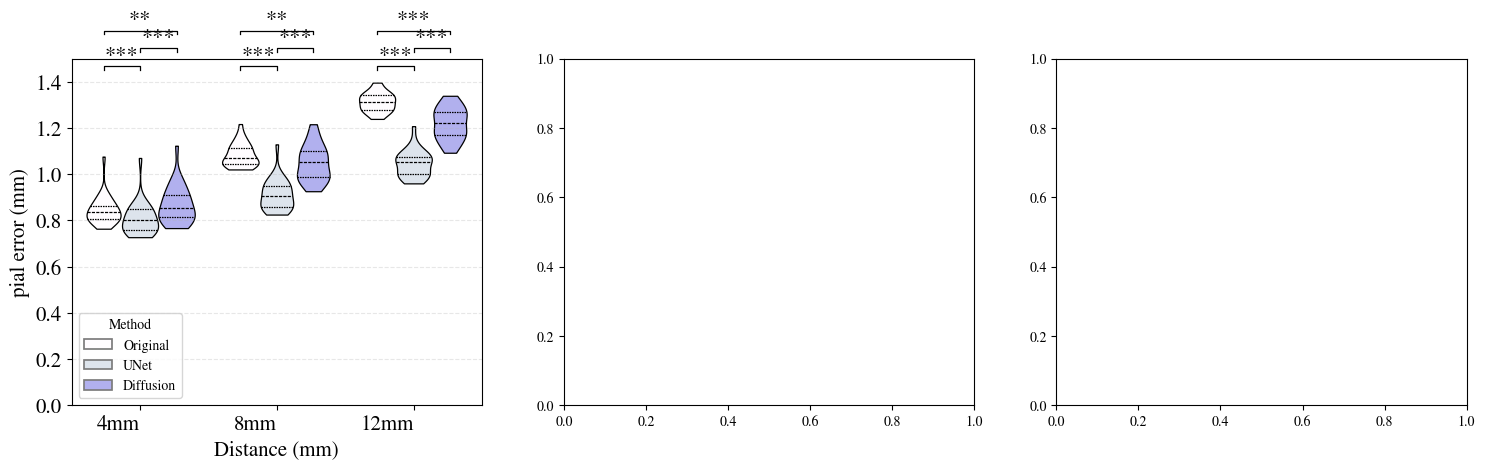

In [ ]:
#### PLOT
lh_long_summary_wm = l_reports_recon.melt(
    id_vars=["label", "file", "distance"],
    value_vars=["err_wm_baseline", "err_wm_unet", "err_wm_diffusion"],
    var_name="method",
    value_name="error"
)
lh_long_summary_pial = l_reports_recon.melt(
    id_vars=["label", "file", "distance"],
    value_vars=["err_pial_baseline", "err_pial_unet", "err_pial_diffusion"],
    var_name="method",
    value_name="error"
)
lh_long_summary_cortical = l_reports_recon.melt(
    id_vars=["label", "file", "distance"],
    value_vars=["cortical_baseline", "cortical_unet", "cortical_diffusion"],
    var_name="method",
    value_name="error"
)


# rh_summary = pd.DataFrame.from_records(rh_reports)
rh_long_summary_wm = r_reports_recon.melt(
    id_vars=["label", "file", "distance"],
    value_vars=["err_wm_baseline", "err_wm_unet", "err_wm_diffusion"],
    var_name="method",
    value_name="error"
)
rh_long_summary_pial = r_reports_recon.melt(
    id_vars=["label", "file", "distance"],
    value_vars=["err_pial_baseline", "err_pial_unet", "err_pial_diffusion"],
    var_name="method",
    value_name="error"
)

rh_long_summary_cortical = r_reports_recon.melt(
    id_vars=["label", "file", "distance"],
    value_vars=["cortical_baseline", "cortical_unet", "cortical_diffusion"],
    var_name="method",
    value_name="error"
)

long_summary_pial =rh_long_summary_pial.copy()
long_summary_pial['error'] = (rh_long_summary_pial['error'] + lh_long_summary_pial['error'])/2 
long_summary_pial["method"] = long_summary_pial["method"].replace({
    "err_pial_baseline": "Original",
    "err_pial_unet":  "UNet",
    "err_pial_diffusion":  "Diffusion"
})
long_summary_wm =rh_long_summary_wm.copy()
long_summary_wm['error'] = (rh_long_summary_wm['error'] + lh_long_summary_wm['error'])/2 
long_summary_wm["method"] = long_summary_wm["method"].replace({
    "err_wm_baseline": "Original",
    "err_wm_unet":  "UNet",
    "err_wm_diffusion":  "Diffusion",
})
long_summary_ct =rh_long_summary_cortical.copy()
long_summary_ct['error'] = (rh_long_summary_cortical['error'] + rh_long_summary_cortical['error'])/2 
long_summary_ct["method"] = long_summary_ct["method"].replace({
    "cortical_baseline": "Original",
    "cortical_unet":  "UNet",
    "cortical_diffusion":  "Diffusion",
})



# ---- choose the distance (label) you want to show ----

# chosen_label = 8  # <-- change this to the label you want (e.g., -1, 1, 2, 3, ...)

#### LOGISTICT FOR CHANGING FONT STYLE
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'
# keep only the two methods you asked for, and the chosen distance
method_order = ["Original", "UNet", "Diffusion"]
dist_order = ['4mm', '8mm', '12mm']
palette = {"Original": "#FFFBFF", "UNet": "#DBE4EE", "Diffusion":"#A7A6F8"}

# means_thickness = pd.DataFrame(index=['wm','pial', "cortical_thick"], columns=method_order+["pvalue_photo_unet"])
distances = ['4mm', '8mm', '12mm']
mean_tables = []
fig, axes = plt.subplots(1,3, figsize=(3*6, 4.5))
methods_cp = ["Orig-UNet", "Orig-Diff", "UNet-Diff"]

pval_tables = []
for i,df in enumerate([long_summary_pial, long_summary_wm, long_summary_ct]):
    if i==0:
        metric = 'pial'
    elif i==1:
        metric = 'wm'
    else:
        metric = 'cortical_thick'

    pval_table = pd.DataFrame(index=distances, columns=methods_cp)
    plot_df = df.copy()    
    # give x a single category so violins appear side-by-side under one tick
    # plot_df["distance"] = f"{chosen_label}mm" if isinstance(chosen_label, (int, float)) else str(chosen_label)
    plot_df = df.groupby(["distance", "file", "method"], as_index=False)['error'].mean()
    ##### NORMALIZATION
    # vmax = plot_df['error'].max()
    # vmin = plot_df['error'].min()
    # plot_df['error'] = (plot_df['error'] - vmin)/(vmax - vmin)

    ax = axes[i]

    pairs = []
    for d in dist_order:
        methods_here = [m for m in method_order
                        if ((plot_df["distance"] == d) & (plot_df["method"] == m)).any()]
        for m1, m2 in combinations(methods_here, 2):
            pairs.append(((d, m1), (d, m2)))   # <-- PAIRS of tuples, not triplets


    sns.violinplot(
        data=plot_df,
        x="distance", y="error",
        hue="method",
        order=dist_order, hue_order=method_order, palette=palette,
        inner="quartile", cut=0, scale="area", dodge=True, ax=ax 
    )

    annotator = Annotator(ax, pairs, data=plot_df, x="distance", y="error", hue="method",order=dist_order, hue_order=method_order)
    annotator.configure(
        test='Wilcoxon', 
        pvalue_thresholds=[(1e-4,'***'), (1e-3,'**'), (0.005,'*'), (1.0,'Ø')],
        text_format='star', loc='outside', line_offset=0.02,
        comparisons_correction=None
    )
    annotator.apply_and_annotate()
    for text in ax.texts:
        text.set_fontsize(16)

    # Keep just one legend
    ax.legend(title="Method", loc="lower left", frameon=True)
    ax.set_xlabel("Distance (mm)", fontsize=15)
    ax.set_ylabel(f"{metric} error (mm)", fontsize=15)
    ax.grid(True, axis="y", linestyle="--", alpha=0.3)
    ax.tick_params(axis="y", labelsize=15)
    plt.setp(ax.get_xticklabels(), ha="right", fontsize=15)
    
    ax.set_ylim(0,1.5)

    for poly in ax.findobj(match=mpl.collections.PolyCollection):
        poly.set_edgecolor("black")
        poly.set_linewidth(.9)
    for ln in ax.lines:
        ln.set_color("black")
        ln.set_linewidth(.9)
    mean_scores = pd.DataFrame()
    for d in distances:
        g1 = plot_df[(plot_df["method"] == "Original") & (plot_df["distance"] == d)]["error"]
        g2 = plot_df[(plot_df["method"] == "UNet") & (plot_df["distance"] == d)]["error"]
        g3 = plot_df[(plot_df["method"] == "Diffusion") & (plot_df["distance"] == d)]["error"]

        mean_scores.loc[d, "Original"] = g1.mean()
        mean_scores.loc[d, "Original-Stdev"] = np.std(g1)
        mean_scores.loc[d, "UNet"] = g2.mean()
        mean_scores.loc[d, "UNet-Stdev"] = np.std(g2)
        mean_scores.loc[d, "Diffusion"] = g3.mean()
        mean_scores.loc[d, "Diffusion-Stdev"] = np.std(g3)
        _,pval12 = wilcoxon(g1, g2)
        _,pval13 = wilcoxon(g1, g3)
        _,pval23 = wilcoxon(g3, g2)
        pval_table["Orig-UNet"][d] = pval12
        pval_table["Orig-Diff"][d] = pval13
        pval_table["UNet-Diff"][d] = pval23
    mean_tables.append(mean_scores)
    pval_tables.append(pval_table)
# plt.tight_layout()
# plt.show()

# fig.savefig(f"/homes/1/ma1282/marina_almeria/dbi/workdir/task_2_dbi_unet_photo_surferrors.svg")

In [2]:
root_dir = "/homes/1/ma1282/marina_almeria/photo_recon_uw/15_registrations_atlas_nifty"
registrations = os.listdir(f"{root_dir}/to_dbi")
            # df = pd.read_csv(file_results, sep="\t", header=None)
            # df.columns = ["Label", "VE", "Dice", "Jaccard"]  # rename columns as needed
            # df = df[df["Label"] != 0]
            
            # for i in label_names:
            #     if i in df["Label"].values:
            #         row = df[df["Label"] == i].copy()
                    
            #         records.append({
            #             "Distance": sub,                # e.g., 4, 8, 12 (mm)
            #             "Case": file,              # subject/case id
            #             "Method": method,          # "unet" or "photo_recon"
            #             "Label": int(row["Label"]),  # region id
            #             "Dice": float(row["Dice"]),
            #             "VE": float(row["VE"]),
            #         })

dice_registrations = pd.DataFrame()
for reg_dir in registrations:
    file_results_dbi = f"{root_dir}/to_dbi/{reg_dir}/synthseg_nonlinear_8mm.json"
    file_results_unet = f"{root_dir}/to_unet/{reg_dir}/synthseg_nonlinear_8mm.json"
    file_results_photo = f"{root_dir}/to_photos/{reg_dir}/synthseg_nonlinear_8mm.json"
    df_dbi = pd.read_csv(file_results_dbi, sep="\t", header=None)
    df_unet= pd.read_csv(file_results_unet, sep="\t", header=None)
    df_photo = pd.read_csv(file_results_photo, sep="\t", header=None)
    dice_registrations.loc[reg_dir, "Dice_photo"] = float(df_photo.mean()[2])
    dice_registrations.loc[reg_dir, "Dice_unet"] = float(df_unet.mean()[2])
    dice_registrations.loc[reg_dir, "Dice_DBI"] = float(df_dbi.mean()[2])
    
    

In [3]:
dice_registrations

,Dice_photo,Dice_unet,Dice_DBI
18-1680,49.162188,52.660938,46.751250
18-1343,39.706333,46.917333,45.440667
19-0138,44.755484,49.235806,46.477419
19-0148,46.434667,51.648667,48.359667
18-1704,53.078333,55.435000,52.245667
18-1705,50.925333,53.016000,46.448333
18-1913,44.409000,47.619333,46.088667
18-2056,55.530645,59.066774,57.133871
18-2259,52.837333,56.958667,55.739333
18-2128,51.700000,56.813438,55.608438


In [ ]:
dice_registrations

,Dice_photo,Dice_unet,Dice_DBI
18-1680,49.162188,52.660938,46.751250
18-1343,39.706333,46.917333,45.440667
19-0138,44.755484,49.235806,46.477419
19-0148,46.434667,51.648667,48.359667
18-1704,53.078333,55.435000,52.245667
18-1705,50.925333,53.016000,46.448333
18-1913,44.409000,47.619333,46.088667
18-2056,55.530645,59.066774,57.133871
18-2259,52.837333,56.958667,55.739333
18-2128,51.700000,56.813438,55.608438


In [10]:
np.max(dice_registrations["Dice_DBI"])

np.float64(58.166250000000005)

In [44]:
mean_tables[0]

,Original,Original-Stdev,UNet,UNet-Stdev,Diffusion,Diffusion-Stdev
4mm,0.844512,0.059492,0.806421,0.068615,0.868312,0.079065
8mm,1.083865,0.048944,0.911548,0.065459,1.048835,0.076410
12mm,1.313015,0.041226,1.045519,0.056382,1.220298,0.067919
